In [141]:
import json
import networkx as nx
with open('./celegansneural.vidi_r.json') as fp:
    graph = json.load(fp)

root = graph['rootIdx']

In [142]:
indexedNodes = {}
clusters = []
for node in graph['nodes']:
    indexedNodes[node['idx']] = node
    indexedNodes[node['idx']]['size'] = 1

In [143]:
origin_graph = nx.Graph()
for node in graph['nodes']:
    if not node['virtualNode']:
        origin_graph.add_node(node['idx'])
for edge in graph['links']:
    origin_graph.add_edge(edge['sourceIdx'], edge['targetIdx'])

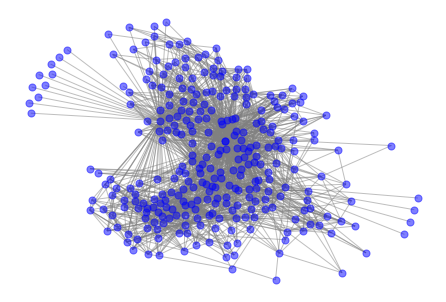

In [144]:
nx.draw(origin_graph, node_size=50, with_labels=False, node_color="blue", alpha=0.5, edge_color="gray")

In [145]:
# elimate nodes with too few childrew(less than 3)
nodeIndexes = sorted(indexedNodes.keys())
for nid in nodeIndexes:
    node = indexedNodes[nid]
    if not node['ancIdx']:
        continue
    # not-leaves node but have children less than 3
    if node['virtualNode'] and len(node['childIdx']) < 3:
        ancNode = indexedNodes[node['ancIdx']]
        ancNodeChildren = set(ancNode['childIdx'])
        ancNodeChildren.remove(nid)
        
        for cid in node['childIdx']:
            indexedNodes[cid]['ancIdx'] = ancNode['idx']
            ancNodeChildren.add(cid)

        ancNode['childIdx'] = list(ancNodeChildren)
        del indexedNodes[nid]

In [146]:
# refine height for every node
# top-down
queue = [graph['rootIdx']]
indexedNodes[graph['rootIdx']]['height'] = 0
minHeight = 0
while len(queue) > 0:
    nid = queue.pop(0)
    nHeight = indexedNodes[nid]['height']
    for c in indexedNodes[nid]['childIdx']:
        indexedNodes[c]['height'] = nHeight - 1
        queue.append(c)
    if len(indexedNodes[nid]['childIdx']) > 0:
        if nHeight - 1 < minHeight:
            minHeight = nHeight - 1
maxHeight = abs(minHeight)

for i, node in indexedNodes.items():
    node['height'] += maxHeight

In [147]:
# build hierarchy
hierarchy = {}
for i in range(maxHeight + 1):
    hierarchy[i] = []
for i, node in indexedNodes.items():
    hierarchy[node['height']].append(i)

In [148]:
def get_ancestor_chain(nid, indexedNodes, explore_list):
    if indexedNodes[nid]['ancIdx']:
        explore_list.append(indexedNodes[nid]['ancIdx'])
        return get_ancestor_chain(indexedNodes[nid]['ancIdx'], indexedNodes, explore_list)
    else:
        return explore_list

for i, node in indexedNodes.items():
    if not node['virtualNode']:
        node['ancestors'] = get_ancestor_chain(i, indexedNodes, [])

In [149]:
# Least Common Ancestor
def get_LCA(source, target, indexedNodes):
    sourceList = indexedNodes[source]['ancestors']
    targetList = set(indexedNodes[target]['ancestors'])
    for a in sourceList:
        if a in targetList:
            return a
    return None

In [150]:
# construct links in quotient graphs
linksInNodes = {}
for link in graph['links']:
    lca = get_LCA(link['sourceIdx'], link['targetIdx'], indexedNodes)
    if lca not in linksInNodes:
        linksInNodes[lca] = {}
    source = link['sourceIdx']
    target = link['targetIdx']
    for i in indexedNodes[source]['ancestors']:
        if i == lca:
            break
        else:
            source = i
    for i in indexedNodes[target]['ancestors']:
        if i == lca:
            break
        else:
            target = i
    if (source, target) not in linksInNodes[lca]:
        linksInNodes[lca][(source, target)] = 0
    linksInNodes[lca][(source, target)] += 1

In [159]:
# construct quotient graphs
# bottom-up construct quotient graphs and compute size for each node
import networkx as nx
from functools import reduce
import math
quotientGraphs = {}
k = 7
for l, nodes in hierarchy.items():
    if l == 0:
        continue
    for nidx in nodes:
        if not indexedNodes[nidx]['virtualNode']:
            continue
        node = indexedNodes[nidx]
        g = nx.Graph()
        for c in node['childIdx']:
            g.add_node(c, size=indexedNodes[c]['size'])
        links = linksInNodes[nidx]
        for link, weight in links.items():
            node0_children = len(indexedNodes[link[0]]['childIdx'])
            if node0_children == 0:
                node0_children = 1
            node1_children = len(indexedNodes[link[1]]['childIdx'])
            if node1_children == 0:
                node1_children = 1
            childrenSum = node0_children + node1_children
            g.add_edge(link[0], link[1], weight=math.log(weight) / (childrenSum))
        size = 0
        for n in g.nodes():
#             size +=  g.nodes[n]['size'] * g.nodes[n]['size']
            size +=  g.nodes[n]['size']
        indexedNodes[nidx]['size'] =  size
        quotientGraphs[nidx] = g

In [160]:
# layout for every quotient graph
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=True,  # Prevent overlap
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=False)
for idx, g in quotientGraphs.items():
    try:
        positions = forceatlas2.forceatlas2_networkx_layout(quotientGraphs[idx], pos=None, iterations=2000)
    except ZeroDivisionError:
        print('error')
        positions = nx.spring_layout(quotientGraphs[idx])
    g.layout = positions

error


In [161]:
from copy import deepcopy
# Treemap Layout for every quotient graph
indexedNodes[root]['rect'] ={
    'width': 10,
    'height': 10,
    'x': -5,
    'y': 5
}
indexedNodes[root]['pos2D'] = (0, 0)

def get_weight(item, indexedNodes):
#     w = len(indexedNodes[item]['childIdx'])
#     if w <= 0:
#         w = 1
#     return w
    return indexedNodes[item]['size']

def accumulate_weight(l, indexedNodes):
    weight = 0
    for item in l:
        weight += get_weight(item, indexedNodes)
    return weight

def split(top_down_list, left_right_list, indexedNodes, rect, weight):
    if len(left_right_list) == 0:
        return
        
    if len(left_right_list) == 1:
        indexedNodes[left_right_list[0]]['rect'] = rect
        return
    half_weight = weight / 2
    
    if rect['width'] > rect['height']:
        # using left-right split
        l_1, w1, l_2, w2 = weight_split(left_right_list, half_weight, indexedNodes)
        r1 ={
            'width': rect['width'] * w1 / weight,
            'height': rect['height'],
            'x': rect['x'],
            'y': rect['y']
        }
        r2 = {
            'width': rect['width'] - r1['width'],
            'height': rect['height'],
            'x': rect['x'] + r1['width'],
            'y': rect['y']
        }
        topdown_l1 = [i for i in top_down_list if i in l_1]
        topdown_l2 = [i for i in top_down_list if i in l_2]
        print("lr1", l_1)
        print("td1", topdown_l1)
        print('lr2', l_2)
        print('td2', topdown_l2)
        split(topdown_l1, l_1, indexedNodes, r1, w1)
        split(topdown_l2, l_2, indexedNodes, r2, w2)
    else:
         # using left-right split
        l_1, w1, l_2, w2 = weight_split(top_down_list, half_weight, indexedNodes)
        r1 ={
            'width': rect['width'],
            'height': rect['height'] * w1 / weight,
            'x': rect['x'],
            'y': rect['y']
        }
        r2 = {
            'width': rect['width'],
            'height': rect['height'] - r1['height'],
            'x': rect['x'],
            'y': rect['y'] + r1['height']
        }
        leftright_l1 = [i for i in left_right_list if i in l_1]
        leftright_l2 = [i for i in left_right_list if i in l_2] 
        split(l_1, leftright_l1, indexedNodes, r1, w1)
        split(l_2, leftright_l2, indexedNodes, r2, w2)
        

def weight_split(l, half_weight, indexedNodes):
    w1 = 0
    tmp = 0
    l_1, l_2 = [], []
    for item in l:
        tmp = w1 + get_weight(item, indexedNodes)
        if abs(half_weight-tmp) > abs(half_weight-w1):
            break
        l_1.append(item)
        w1 = tmp
    l_2 = []
    w2 = 0
    for item in l:
        if item in l_1:
            continue
        else:
            l_2.append(item)
            w2 += get_weight(item, indexedNodes)
    return l_1, w1, l_2, w2


def treemap_layout(nid, indexedNodes):
#     if not indexedNodes[nid]['virtualNode']:
#         return
    rect = indexedNodes[nid]['rect']
    if not indexedNodes[indexedNodes[nid]['childIdx'][0]]['virtualNode']:
        cx = rect['x'] + rect['width'] / 2
        cy = rect['y'] + rect['height'] / 2
        size = min(rect['width'], rect['height']) / 2
        r_list = [ math.sqrt(pos[0] * pos[0] + pos[1] * pos[1]) for i, pos in quotientGraphs[nid].layout.items() ]
        pos_list = [ pos for i, pos in quotientGraphs[nid].layout.items() ]
        mx, my = 0, 0
        for p in pos_list:
            mx += p[0]
            my += p[1]
        mx, my = mx / len(pos_list), my / len(pos_list)
        max_radius = max(r_list)
        scaling_ratio = float(size) / max_radius
        for c in indexedNodes[nid]['childIdx']:
            dx = quotientGraphs[nid].layout[c][0] - mx
            dy = quotientGraphs[nid].layout[c][1] - my
            indexedNodes[c]['pos2D'] = (cx + dx * scaling_ratio, cy + dy * scaling_ratio)
        return
    rect = indexedNodes[nid]['rect']
    # sort the children
    top_down_list = deepcopy(indexedNodes[nid]['childIdx'])
    top_down_list = sorted(top_down_list, key=lambda x: quotientGraphs[nid].layout[x][1])
    left_right_list = deepcopy(indexedNodes[nid]['childIdx'])
    left_right_list = sorted(left_right_list, key=lambda x: quotientGraphs[nid].layout[x][0])
    weight = accumulate_weight(top_down_list, indexedNodes)
    split(top_down_list, left_right_list, indexedNodes, rect, weight)
    for c in indexedNodes[nid]['childIdx']:
        treemap_layout(c, indexedNodes)
        
        
treemap_layout(root, indexedNodes)

lr1 [308, 299]
td1 [299, 308]
lr2 [310, 306]
td2 [306, 310]
lr1 [310]
td1 [310]
lr2 [306]
td2 [306]
lr1 [307, 305]
td1 [305, 307]
lr2 [311, 304]
td2 [304, 311]
lr1 [307]
td1 [307]
lr2 [305]
td2 [305]
lr1 [301]
td1 [301]
lr2 [302]
td2 [302]
lr1 [309, 300]
td1 [300, 309]
lr2 [303, 298]
td2 [303, 298]


In [97]:
# 2D version layout
# Top-down
indexedNodes[root]['pos2D'] = (0, 0)
def layout_by_quotient_graph(nid, indexedNodes):
    if not indexedNodes[nid]['virtualNode']:
        return 
    size = indexedNodes[nid]['size']
    x = indexedNodes[nid]['pos2D'][0]
    y = indexedNodes[nid]['pos2D'][1]
    r_list = [ math.sqrt(pos[0] * pos[0] + pos[1] * pos[1]) for i, pos in quotientGraphs[nid].layout.items() ]
    pos_list = [ pos for i, pos in quotientGraphs[nid].layout.items() ]
    mx, my = 0, 0
    for p in pos_list:
        mx += p[0]
        my += p[1]
    mx, my = mx / len(pos_list), my / len(pos_list)
    max_radius = max(r_list)
    scaling_ratio = float(size) / max_radius
    for c in indexedNodes[nid]['childIdx']:
        dx = quotientGraphs[nid].layout[c][0] - mx
        dy = quotientGraphs[nid].layout[c][1] - my
        indexedNodes[c]['pos2D'] = (x + dx * scaling_ratio, y + dy * scaling_ratio)
        layout_by_quotient_graph(c, indexedNodes)

layout_by_quotient_graph(root, indexedNodes)

E:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


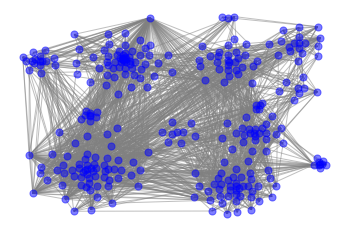

In [162]:
position_2d = {}
for i, node in indexedNodes.items():
    if not node['virtualNode']:
        position_2d[node['idx']] = node['pos2D']
nx.draw_networkx_nodes(origin_graph, position_2d, node_size=50, with_labels=False, node_color="blue", alpha=0.5)
nx.draw_networkx_edges(origin_graph, position_2d, edge_color="gray", alpha=0.5)
plt.axis('off')
plt.show()

In [91]:
# save the 2d layout to file

In [92]:
# import numpy as np
posX = np.array([positions[i][0] for i in positions])
posY = np.array([positions[i][1] for i in positions])
maxX = posX.max()
minX = posX.min()
maxY = posY.max()
minY = posY.min()

NameError: name 'np' is not defined

In [93]:
# Clamp y to [0, Pi]
# Clamp x to [-pi, pi]
sPositions = {}
sx = []
sy = []
sz = []
for i, c in positions.items():
    x = (c[0] - minX) * np.pi / (maxX - minX) 
    y = -0.7 * (c[1] - minY) * np.pi / (maxY - minY)
    sx.append(np.sin(y) * np.cos(x))
    sy.append(np.sin(y) * np.sin(x))
    sz.append(np.cos(y))
    sPositions[i] = [sx[-1], sy[-1], sz[-1]]

NameError: name 'minX' is not defined

In [100]:
import json
json_obj = {
    "nodes": [],
    "links": graph['links'],
    "rootIdx": root
}
for node in graph['nodes']:
    if node['idx'] in indexedNodes:
        json_obj['nodes'].append(node)
with open("./layout/celegansneural-layout.json", 'w') as fp:
    json.dump(json_obj, fp)

In [359]:
json_obj

 'targetIdx': 22},
  {'sourceIdx': 8, 'targetIdx': 41},
  {'sourceIdx': 8, 'targetIdx': 51},
  {'sourceIdx': 8, 'targetIdx': 68},
  {'sourceIdx': 8, 'targetIdx': 77},
  {'sourceIdx': 8, 'targetIdx': 78},
  {'sourceIdx': 8, 'targetIdx': 90},
  {'sourceIdx': 8, 'targetIdx': 111},
  {'sourceIdx': 9, 'targetIdx': 16},
  {'sourceIdx': 9, 'targetIdx': 22},
  {'sourceIdx': 9, 'targetIdx': 23},
  {'sourceIdx': 9, 'targetIdx': 41},
  {'sourceIdx': 9, 'targetIdx': 64},
  {'sourceIdx': 9, 'targetIdx': 93},
  {'sourceIdx': 9, 'targetIdx': 104},
  {'sourceIdx': 9, 'targetIdx': 108},
  {'sourceIdx': 10, 'targetIdx': 11},
  {'sourceIdx': 10, 'targetIdx': 60},
  {'sourceIdx': 10, 'targetIdx': 72},
  {'sourceIdx': 10, 'targetIdx': 74},
  {'sourceIdx': 10, 'targetIdx': 81},
  {'sourceIdx': 10, 'targetIdx': 84},
  {'sourceIdx': 10, 'targetIdx': 98},
  {'sourceIdx': 10, 'targetIdx': 102},
  {'sourceIdx': 10, 'targetIdx': 107},
  {'sourceIdx': 11, 'targetIdx': 24},
  {'sourceIdx': 11, 'targetIdx': 28},
  {

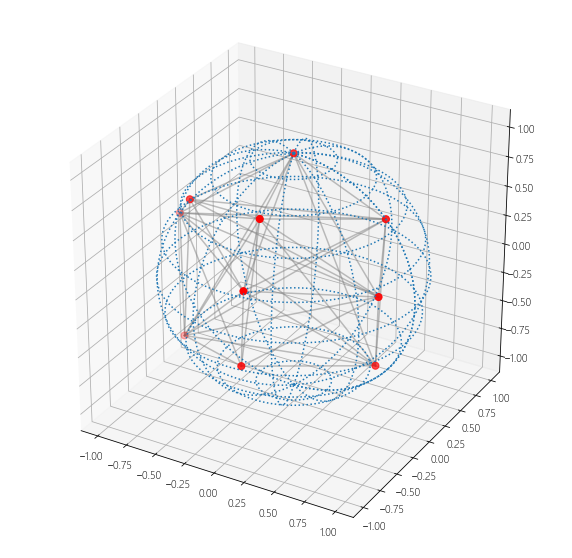

In [58]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(sx, sy, sz, c='r', s=50)

# center and radius
center = [0, 0, 0]
radius = 1

# data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

for e in G.edges():
    p1 = sPositions[e[0]]
    p2 = sPositions[e[1]]
    ax.plot([p1[0],p2[0]],[p1[1], p2[1]],[p1[2], p2[2]],color = 'gray', alpha=0.5)

ax.plot_wireframe(x, y, z, rstride=10, cstride=10, linestyle=':')

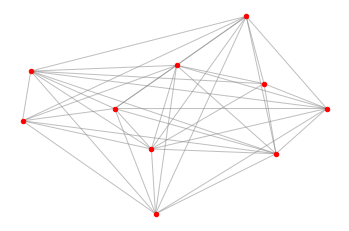

In [45]:
nx.draw_networkx_nodes(G, positions, node_size=20, with_labels=False, node_color="r", alpha=1)
nx.draw_networkx_edges(G, positions, edge_color="gray", alpha=0.5)
plt.axis('off')
plt.show()

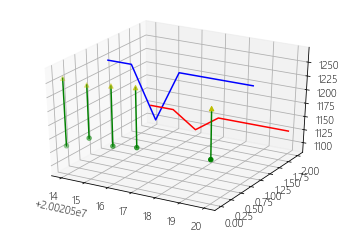

In [9]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

dates       = [20020514, 20020515, 20020516, 20020517, 20020520]
highs       = [1135, 1158, 1152, 1158, 1163]
lows        = [1257, 1253, 1259, 1264, 1252]
upperLimits = [1125.0, 1125.0, 1093.75, 1125.0, 1125.0]
lowerLimits = [1250.0, 1250.0, 1156.25, 1250.0, 1250.0]

zaxisvalues0= [0, 0, 0, 0, 0]
zaxisvalues1= [1, 1, 1, 1, 1]
zaxisvalues2= [2, 2, 2, 2, 2]

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

ax.plot(dates, zaxisvalues1, lowerLimits, color = 'b')
ax.plot(dates, zaxisvalues2, upperLimits, color = 'r')

for i,j,k,h in zip(dates,zaxisvalues0,lows,highs):
    ax.plot([i,i],[j,j],[k,h],color = 'g')

ax.scatter(dates, zaxisvalues0, highs, color = 'g', marker = "o")
ax.scatter(dates, zaxisvalues0, lows, color = 'y', marker = "^")

matplotlib.pyplot.show()

In [10]:
np.sin(np.pi / 2)

1.0